In [1]:
%load_ext autoreload
%autoreload 2
from qiskit_metal import draw, Dict, designs, MetalGUI
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal
from just_claw import TransmonClaw
# ?metal.qlibrary.core.QComponent.add_qgeometry

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

# dir(QComponent)
cpw_width = '11.7um'

design._chips.main.size.size_x = '5mm'
design._chips.main.size.size_y = '5mm'
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee

from collections import OrderedDict

import numpy as np

xmon1_options = dict(
    connection_pads = dict(
        readout = dict(
            connector_location='90',
            connector_type='0',
            claw_length="150um",
            ground_spacing='4.1um',
            claw_gap='5.1um',
            claw_width='15um',
            claw_cpw_length="0um",
            claw_cpw_width="10um"
        ),
    ),
    cross_width='30um',
    cross_length="100um",
    cross_gap='30um',
    orientation='-90',
    pos_x='-1500um',
    pos_y='1200um',
    # aedt_hfss_inductance=inductance,
    # hfss_inductance=inductance, 
    # q3d_inductance=inductance,
    # aedt_q3d_inductance=inductance
    hfss_inductance = 9.686e-09,
    hfss_capacitance = 0,
    hfss_resistance = 0,
    hfss_mesh_kw_jj = 7e-06,
    q3d_inductance = "10nH",
    q3d_capacitance = 0,
    q3d_resistance = 0,
    q3d_mesh_kw_jj = 7e-06,
    aedt_q3d_inductance = 1e-08,
    aedt_q3d_capacitance = 0,
    aedt_hfss_inductance = 9.686e-09,
    aedt_hfss_capacitance = 0
)

# Create a new Transmon Cross object with name 'Q1'
# q = TransmonClaw(design, 'Q', options=xmon1_options)

clt1_opts = Dict(prime_width = cpw_width,
                prime_gap = '5.1um',
                second_width = cpw_width,
                second_gap = '5.1um',
                coupling_space = '7.9um',
                coupling_length = '225um',
                open_termination = False,
                orientation = '-90',
                pos_y = '1200um',
                down_length = '50um')

# clt = CoupledLineTee(design, 'clt', clt1_opts)

cpw1_opts = Dict(pin_inputs = Dict(start_pin = Dict(component = 'clt',
                                                    pin = 'second_end'),
                                   end_pin = Dict(component = 'Q',
                                                  pin = 'readout')),
                # lead = Dict(start_straight = '50um',
                #             # start_jogged_extension = jogsS),
                # ),
                fillet = '49.9um',
                total_length = '3885.5930858724796um',#'3893.8166um', # '6776um',
                trace_width = cpw_width,
                # meander = Dict(spacing = '100um',
                #                asymmetry = '-115um'),
                prevent_short_edges = "true",
                trace_gap = '5.1um',)
# cpw = RouteMeander(design, 'cpw', options = cpw1_opts)

# gui.rebuild()
# gui.autoscale()
# gui.zoom_on_components(['clt5', 'Q5'])
# gui.screenshot()

In [2]:
import pandas as pd

In [3]:
aggregate_df = pd.read_csv("aggregate_df_1.csv")
aggregate_df

,updated_cross_lengths,updated_claw_lengths,updated_resonator_lengths,updated_coupling_dimensions,LJs,indices
0,213.641467,191.013989,3638.606336,236.406312,9.999932,"(7830, 1014)"
1,181.976585,145.265973,4587.817766,368.072758,10.000181,"(8615, 5533)"
2,181.004312,134.799356,4146.703745,92.527234,10.000019,"(3485, 2282)"
3,190.713307,134.451299,2990.119838,197.951335,10.000162,"(3465, 110)"
4,199.498695,134.246074,3582.612956,495.230165,10.000235,"(3415, 7756)"


In [4]:
Lj_vals = aggregate_df["LJs"].tolist()
predicted_cross_length = aggregate_df["updated_cross_lengths"].tolist()
predicted_claw_length = aggregate_df["updated_claw_lengths"].tolist()
cpw_lengths = aggregate_df["updated_resonator_lengths"].tolist()
cplr_lengths = aggregate_df["updated_coupling_dimensions"].tolist()

In [5]:
ground_spacing = 4.1

In [6]:
comps_available = {
    "Sabrina":0,
    "Glinda":1,
    "Saruman":2,
    "VM1":3, #?
    "VM2":4, #?
}

In [7]:
indexes = (0,1,2)
version = "agg1"
comp_id = "Sabrina"  # Replace with actual computer name

# Eigenmode Sim (CLT + CPW + Claw)

In [8]:
from qiskit_metal.analyses.quantization import EPRanalysis
import pyEPR as epr
from pyaedt import Hfss
from utils import *
from objects import *
from datetime import datetime
import pprint

In [9]:
eig_q12bus = EPRanalysis(design, "hfss")

INFO 04:38PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:38PM [load_ansys_project]: 	Opened Ansys App
INFO 04:38PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 04:38PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   4p1_xmon_LOM_sweep



Starting the Simulation


INFO 04:38PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 04:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:38PM [connect]: 	Connected to project "4p1_xmon_LOM_sweep" and design "CavitySweep_hfss" 😀 

INFO 04:38PM [connect_design]: 	Opened active design
	Design:    CavitySweep7 [Solution type: Eigenmode]
WARNING 04:38PM [connect_setup]: 	No design setup detected.
WARNING 04:38PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


INFO 04:38PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
{'mesh1': {'objects': ['prime_cpw_cplr', 'second_cpw_cplr', 'trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '7um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project 4p1_xmon_LOM_sweep set to active.


INFO:Global:Project 4p1_xmon_LOM_sweep set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: aedt file load time 0.1250004768371582


INFO:Global:aedt file load time 0.1250004768371582


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 04:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 04:40PM [analyze]: Analyzing setup Setup
05:07PM 59s INFO [get_f_convergence]: Saved convergences to d:\andre\full device epr\hfss_eig_f_convergence.csv


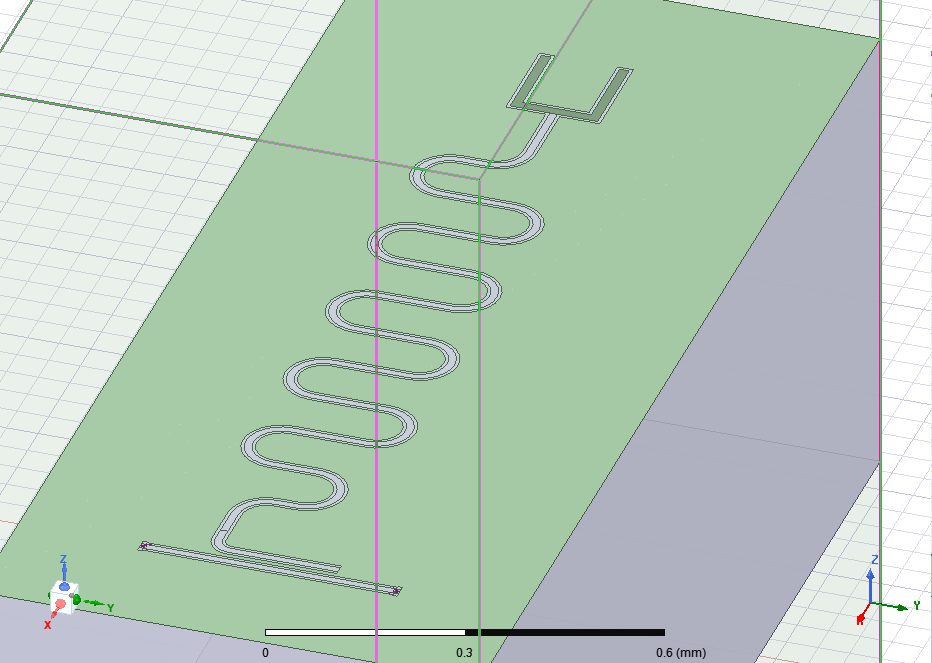

INFO 05:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


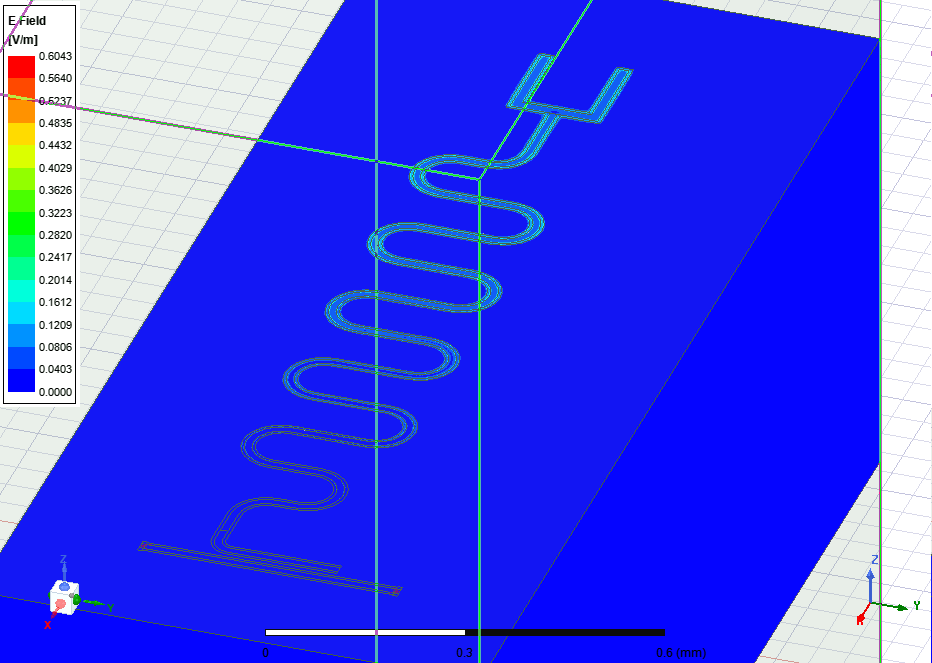

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 8.319 GHz
Q = 38338.2
kappa = 0.217 MHz

Starting the Simulation


INFO 05:08PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:08PM [load_ansys_project]: 	Opened Ansys App
INFO 05:08PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 05:08PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   4p1_xmon_LOM_sweep
INFO 05:09PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]
INFO 05:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:09PM [connect]: 	Connected to project "4p1_xmon_LOM_sweep" and design "CavitySweep_hfss" 😀 

INFO 05:10PM [connect_design]: 	Opened active design
	Design:    CavitySweep8 [Solution type: Eigenmode]
WARNING 05:10PM [connect_setup]: 	No design setup detected.
WARNING 05:10PM [connect_setup]: 	Creating eigenmode default setup.
INFO 05:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


INFO 05:11PM [connect_design]: 	Opened active design
	Design:    CavitySweep_hfss [Solution type: Eigenmode]


creaing porst
Sim rendered into HFSS!
{'mesh1': {'objects': ['prime_cpw_cplr', 'second_cpw_cplr', 'trace_cpw', 'readout_connector_arm_claw'], 'MaxLength': '7um'}}
pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\AnsysEM\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


INFO:Global:Python version 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 17:59:51) [MSC v.1935 64 bit (AMD64)]


pyaedt INFO: Project 4p1_xmon_LOM_sweep set to active.


INFO:Global:Project 4p1_xmon_LOM_sweep set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 05:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:12PM [analyze]: Analyzing setup Setup
05:44PM 44s INFO [get_f_convergence]: Saved convergences to d:\andre\full device epr\hfss_eig_f_convergence.csv


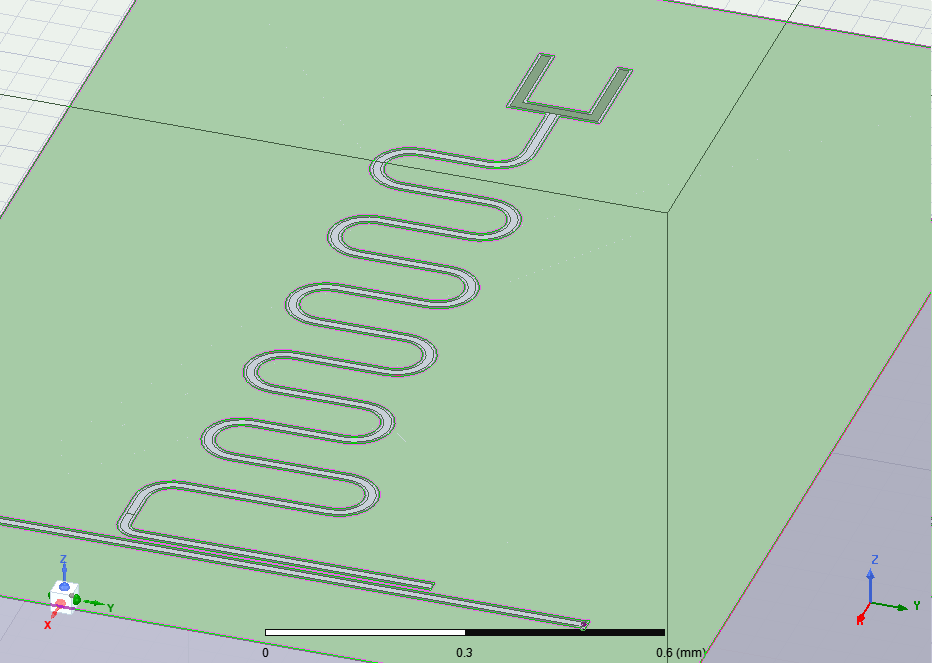

INFO 05:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


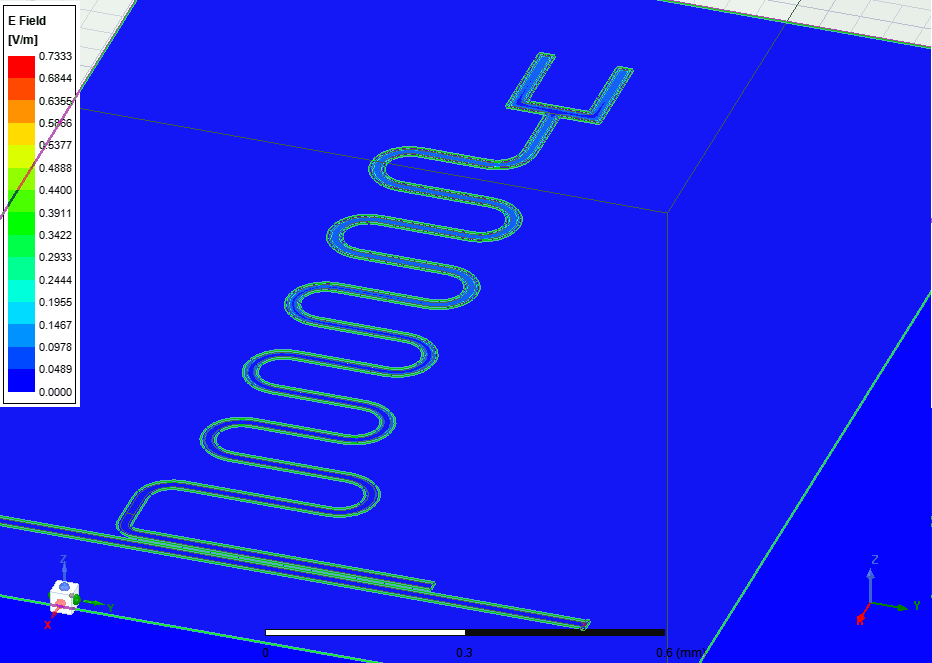

Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
Design "CavitySweep_hfss" info:
	# eigenmodes    1
	# variations    1
freq = 6.677 GHz
Q = 7708.8
kappa = 0.866 MHz


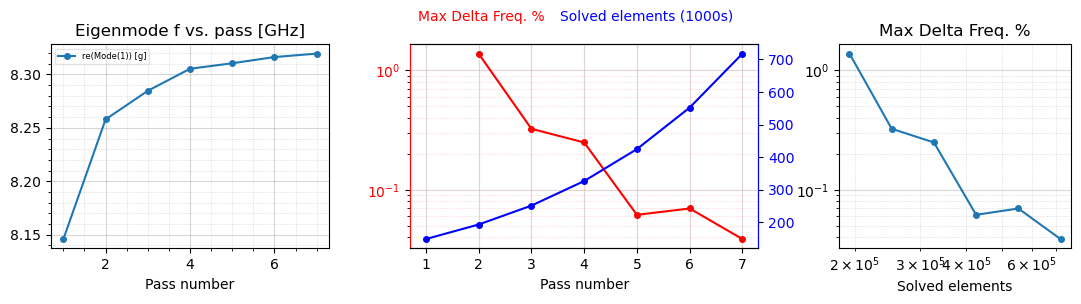

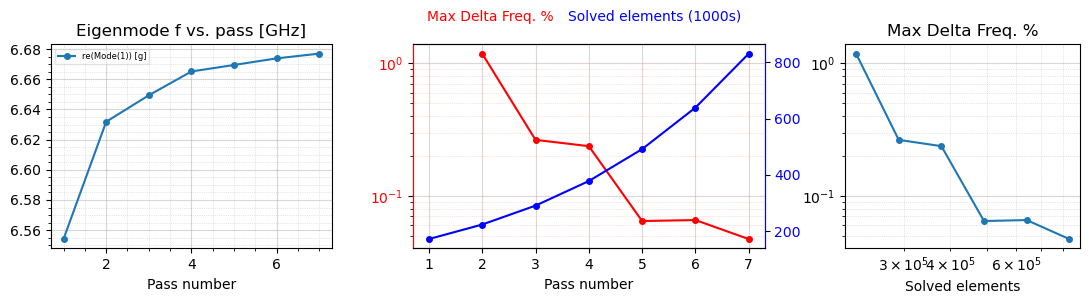

In [10]:
%matplotlib inline
eig_q12bus = EPRanalysis(design, "hfss")
hfss = eig_q12bus.sim.renderer

for i, (cross_length, claw_length, Lj, cpw_len, cplr_len) in enumerate(zip(predicted_cross_length, predicted_claw_length, Lj_vals, cpw_lengths, cplr_lengths)):
    if i not in indexes:
        continue
    # print(i)
    xmon1_options["connection_pads"]["readout"]["claw_length"] = f"{claw_length}um"
    xmon1_options["connection_pads"]["readout"]["ground_spacing"] = f"{ground_spacing}um"
    xmon1_options["aedt_hfss_inductance"]=Lj,
    xmon1_options["hfss_inductance"]=Lj, 
    xmon1_options["q3d_inductance"]=Lj,
    xmon1_options["aedt_q3d_inductance"]=Lj

    cpw1_opts["total_length"] = f"{cpw_len}um"
    clt1_opts["coupling_length"] = f"{int(round(cplr_len, 0))}um"
    
    # create_claw(xmon1_options, cpw_len, design)
    # cplr = create_coupler(clt1_opts, design)
    # create_cpw(cpw1_opts, cplr, design)
    # gui.rebuild()
    # gui.autoscale()

    v2_opts = Dict(
        claw_opts = xmon1_options,
        cplr_opts = clt1_opts,
        cpw_opts = cpw1_opts
    )
    # pprint.pprint(v2_opts)
    now = datetime.now()
    #print(xmon1_options)
    #print(cpw1_opts)
    #print(clt1_opts)
    print()
    CLT_epr_sweep(design = design, sweep_opts=v2_opts, filename = f"cavity_claw_num{i}_{comp_id}_v{version}")


# LOM Analysis

In [11]:
# xmon = TransmonCross(design = design, options = xmon1_options, name = "xmon")

In [9]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [10]:
c1.sim.setup.reuse_selected_design = False
c1.sim.setup.reuse_setup = False

# example: update single setting
c1.sim.setup.max_passes = 30
c1.sim.setup.min_converged_passes = 1
c1.sim.setup.percent_error = 0.1
c1.sim.setup.name = 'sweep_setup'

In [11]:
def do_LOM_qubitonly(cross_length, claw_length, Lj, i):
    qname = 'xmon'
    cname = 'readout'

    # design.components[qname].options['connection_pads']['readout']['claw_length'] = f'{claw_length}um'
    # design.components[qname].options['cross_length'] = f'{cross_length}um'
    # design.components[qname].options['hfss_inductance'] = Lj
    # design.components[qname].options['aedt_hfss_inductance'] = Lj
    # design.components[qname].options['q3d_inductance'] = Lj
    # design.components[qname].options['aedt_q3d_inductance'] = Lj
    # xmon1_options["cross_width"] = f"15um"
    xmon1_options["cross_length"] = f"{cross_length}um"
    xmon1_options["connection_pads"]["readout"]["claw_length"] = f"{claw_length}um"
    # xmon1_options["connection_pads"]["readout"]["ground_spacing"] = f"{ground_spacing}um"
    xmon1_options["aedt_hfss_inductance"]=Lj,
    xmon1_options["hfss_inductance"]=Lj, 
    xmon1_options["q3d_inductance"]=Lj,
    xmon1_options["aedt_q3d_inductance"]=Lj
    q = TransmonCross(design, qname, options=xmon1_options)
    design.rebuild()
    selection = [qname]
    open_pins = [(qname, cname)]
    print(q.options)
    c1.sim.renderer.clean_active_design()
    c1.sim.run(name = 'LOMv2.0', components=selection,
               open_terminations=open_pins)
    cap_df = c1.sim.capacitance_matrix

    print(f'For Qubit_{i}, the cap matrix is...')
    print(cap_df)

    data = {
        "design_options": design.components[qname].options,
        "data": {
            "cross_to_ground": 0 if 'ground_main_plane' not in cap_df.loc[f'cross_{qname}'] else cap_df.loc[f'cross_{qname}']['ground_main_plane'],
            "claw_to_ground": 0 if 'ground_main_plane' not in cap_df.loc[f'{cname}_connector_arm_{qname}'] else cap_df.loc[f'{cname}_connector_arm_{qname}']['ground_main_plane'],
            "cross_to_claw": cap_df.loc[f'cross_{qname}'][f'{cname}_connector_arm_{qname}'],
            "cross_to_cross": cap_df.loc[f'cross_{qname}'][f'cross_{qname}'],
            "claw_to_claw": cap_df.loc[f'{cname}_connector_arm_{qname}'][f'{cname}_connector_arm_{qname}'],
            "ground_to_ground": 0 if 'ground_main_plane' not in cap_df.loc[f'cross_{qname}'] else cap_df.loc['ground_main_plane']['ground_main_plane']
        },
        "sim_info": {
            "setup": c1.sim.setup,
            "renderer_options": c1.sim.renderer.options
        }
    }
    save_simulation_data_to_json(data, filename = f"qubitonly_num{i}_{comp_id}_v{version}")


In [12]:
all_cap_matricies = []

for i, (cross_length, claw_length, Lj) in enumerate(zip(predicted_cross_length, predicted_claw_length, Lj_vals)):
    # print(claw_length)
    if i not in indexes:
        continue
    do_LOM_qubitonly(cross_length, claw_length, Lj, i)

INFO 05:53PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:53PM [load_ansys_project]: 	Opened Ansys App
INFO 05:53PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 05:53PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   4p1_xmon_LOM_sweep


{'pos_x': '-1500um', 'pos_y': '1200um', 'orientation': '-90', 'chip': 'main', 'layer': '1', 'connection_pads': {'readout': {'connector_type': '0', 'claw_length': '191.01398881421176um', 'ground_spacing': '4.1um', 'claw_width': '15um', 'claw_gap': '5.1um', 'claw_cpw_length': '0um', 'claw_cpw_width': '10um', 'connector_location': '90'}}, 'cross_width': '30um', 'cross_length': '213.641467334455um', 'cross_gap': '30um', 'hfss_inductance': (9.999932352646574,), 'hfss_capacitance': 0, 'hfss_resistance': 0, 'hfss_mesh_kw_jj': 7e-06, 'q3d_inductance': (9.999932352646574,), 'q3d_capacitance': 0, 'q3d_resistance': 0, 'q3d_mesh_kw_jj': 7e-06, 'gds_cell_name': 'my_other_junction', 'aedt_q3d_inductance': 9.999932352646574, 'aedt_q3d_capacitance': 0, 'aedt_hfss_inductance': (9.999932352646574,), 'aedt_hfss_capacitance': 0}


INFO 05:53PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d1 [Solution type: Q3D]
INFO 05:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:53PM [connect]: 	Connected to project "4p1_xmon_LOM_sweep" and design "LOMv2.0_q3d1" 😀 

INFO 05:53PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d2 [Solution type: Q3D]
WARNING 05:53PM [connect_setup]: 	No design setup detected.
WARNING 05:53PM [connect_setup]: 	Creating Q3D default setup.
INFO 05:53PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:53PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:53PM [analyze]: Analyzing setup sweep_setup


<COMObject GetModule>


INFO 05:54PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpyi1rhqqx.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:54PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpbb6trovc.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:54PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp31y7rjhc.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 05:54PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp5dbshbdu.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 05:54PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpazb8d9p0.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell,

For Qubit_0, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                   110.96473         -101.58163   
ground_main_plane           -101.58163          242.01399   
readout_connector_arm_xmon    -7.12568          -88.54086   

                            readout_connector_arm_xmon  
cross_xmon                                    -7.12568  
ground_main_plane                            -88.54086  
readout_connector_arm_xmon                    96.21314  
{'pos_x': '-1500um', 'pos_y': '1200um', 'orientation': '-90', 'chip': 'main', 'layer': '1', 'connection_pads': {'readout': {'connector_type': '0', 'claw_length': '145.2659732558795um', 'ground_spacing': '4.1um', 'claw_width': '15um', 'claw_gap': '5.1um', 'claw_cpw_length': '0um', 'claw_cpw_width': '10um', 'connector_location': '90'}}, 'cross_width': '30um', 'cross_length': '181.97658471821416um', 'cross_gap': '30um', 'hfss_inductance': (10.000180764463806,), 'hfss_capacitance': 0, 'hfss_r

INFO 05:54PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d3 [Solution type: Q3D]
WARNING 05:54PM [connect_setup]: 	No design setup detected.
WARNING 05:54PM [connect_setup]: 	Creating Q3D default setup.
INFO 05:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:55PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:55PM [analyze]: Analyzing setup sweep_setup


<COMObject GetModule>


INFO 05:56PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp3pa55y3u.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:56PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp361z5_zs.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:56PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp97clyysp.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 05:56PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpn9inu6t3.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 05:56PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpblay7rz_.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell,

For Qubit_1, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                    94.22757          -86.90350   
ground_main_plane            -86.90350          210.49864   
readout_connector_arm_xmon    -5.17046          -75.12976   

                            readout_connector_arm_xmon  
cross_xmon                                    -5.17046  
ground_main_plane                            -75.12976  
readout_connector_arm_xmon                    80.85880  
{'pos_x': '-1500um', 'pos_y': '1200um', 'orientation': '-90', 'chip': 'main', 'layer': '1', 'connection_pads': {'readout': {'connector_type': '0', 'claw_length': '134.79935568734177um', 'ground_spacing': '4.1um', 'claw_width': '15um', 'claw_gap': '5.1um', 'claw_cpw_length': '0um', 'claw_cpw_width': '10um', 'connector_location': '90'}}, 'cross_width': '30um', 'cross_length': '181.00431249856769um', 'cross_gap': '30um', 'hfss_inductance': (10.000019073520054,), 'hfss_capacitance': 0, 'hfss_

INFO 05:57PM [connect_design]: 	Opened active design
	Design:    LOMv2.0_q3d4 [Solution type: Q3D]
WARNING 05:57PM [connect_setup]: 	No design setup detected.
WARNING 05:57PM [connect_setup]: 	Creating Q3D default setup.
INFO 05:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:57PM [get_setup]: 	Opened setup `sweep_setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 05:57PM [analyze]: Analyzing setup sweep_setup


<COMObject GetModule>


INFO 05:59PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp6x7g7872.txt, C, , sweep_setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:59PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpqkmz7p5e.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 05:59PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp5tll8bji.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 05:59PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmpdgd_cml6.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 05:59PM [get_matrix]: Exporting matrix data to (C:\Users\lfl\AppData\Local\Temp\tmp112l5lgf.txt, C, , sweep_setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell,

For Qubit_2, the cap matrix is...
                            cross_xmon  ground_main_plane  \
cross_xmon                    93.78690          -86.97355   
ground_main_plane            -86.97355          207.26116   
readout_connector_arm_xmon    -4.70107          -71.78414   

                            readout_connector_arm_xmon  
cross_xmon                                    -4.70107  
ground_main_plane                            -71.78414  
readout_connector_arm_xmon                    77.00381  
